In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

# 1. 전체 데이터 생성 (불균형: 70% vs 30%)
X, y = make_classification(n_samples=1000, n_features=10, weights=[0.3, 0.7], flip_y=0, random_state=42)

# 2. 먼저 훈련셋과 테스트셋으로 나누기 (비율 유지)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. 테스트셋을 균등하게 라벨 분포 맞춰서 샘플링
X_test_0 = X_test_full[y_test_full == 0]
X_test_1 = X_test_full[y_test_full == 1]

n_samples = min(len(X_test_0), len(X_test_1))  # 균형 맞추기 위해 더 적은 쪽에 맞춤

# 각 클래스에서 균등하게 샘플링
np.random.seed(42)
idx_0 = np.random.choice(len(X_test_0), n_samples, replace=False)
idx_1 = np.random.choice(len(X_test_1), n_samples, replace=False)

X_test_balanced = np.vstack((X_test_0[idx_0], X_test_1[idx_1]))
y_test_balanced = np.array([0] * n_samples + [1] * n_samples)

# X_train 그대로 사용하고, 테스트셋은 균형 맞춰 반환
X_train = X_train_full
y_train = y_train_full
X_test = X_test_balanced
y_test = y_test_balanced

In [2]:
from collections import Counter

print(Counter(y_train))
print(Counter(y_test))

Counter({1: 491, 0: 209})
Counter({0: 91, 1: 91})


In [3]:
# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

In [4]:
import seaborn as sns

# 평가
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# 결과 정리
metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1": f1
})

metrics_df

,Accuracy,Precision,Recall,F1
0,0.824176,0.770642,0.923077,0.84


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\NGULIM.TTF'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font)

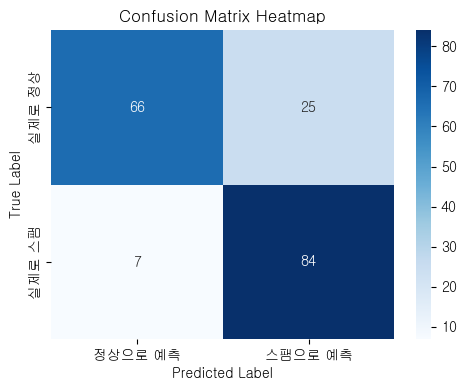

In [15]:
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 히트맵 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상으로 예측', '스팸으로 예측'],
            yticklabels=['실제로 정상', '실제로 스팸'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

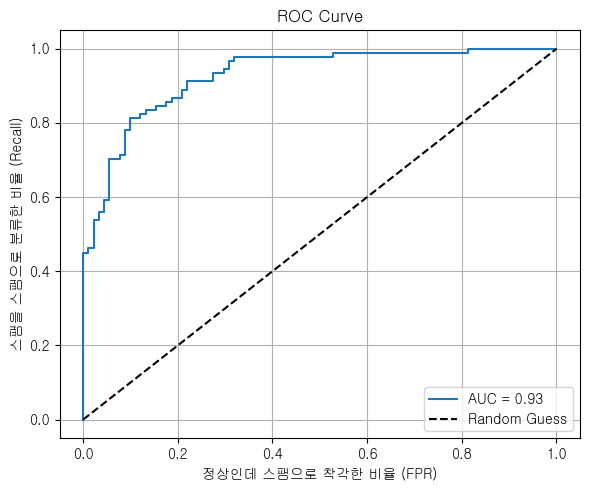

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

# 예측 확률 추출
y_scores = model.predict_proba(X_test)[:, 1]

# ROC curve 계산
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

# ROC 곡선 시각화
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("정상인데 스팸으로 착각한 비율 (FPR)")
plt.ylabel("스팸을 스팸으로 분류한 비율 (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 정상 메일을 스팸으로 분류하는 비율을 낮춰보자 (Precision을 올려보자)

In [7]:
# 일반 메일을 좀 더 많이 학습하도록 하자.
X_train_nospam = X_train[y_train == 0]
y_train_nospam = y_train[y_train == 0]

X_train = np.concatenate([X_train, X_train_nospam])
y_train = np.concatenate([y_train, y_train_nospam])

In [11]:
# class_weight를 'balanced'로 설정하여 적은 라벨에 더 집중할 수 있도록.
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

In [12]:
# 평가
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred)

# 결과 정리
metrics_df2 = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1": f1
})

metrics_df_total = pd.concat([metrics_df, metrics_df2])
metrics_df_total.index = ["before", "after"]

metrics_df_total

,Accuracy,Precision,Recall,F1
before,0.824176,0.770642,0.923077,0.840000
after,0.840659,0.829787,0.857143,0.843243


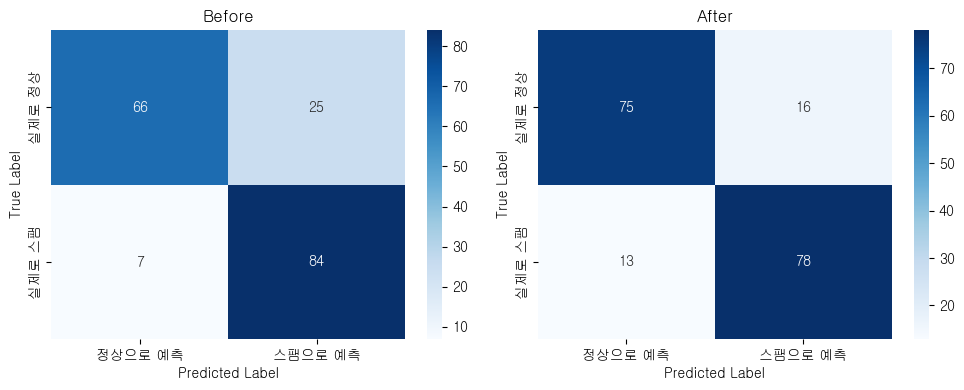

In [13]:
# 혼동 행렬 히트맵 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상으로 예측', '스팸으로 예측'],
            yticklabels=['실제로 정상', '실제로 스팸'],
           ax=ax[0])
ax[0].set_title("Before")
ax[0].set_xlabel("Predicted Label")
ax[0].set_ylabel("True Label")

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['정상으로 예측', '스팸으로 예측'],
            yticklabels=['실제로 정상', '실제로 스팸'],
           ax=ax[1])
ax[1].set_title("After")
ax[1].set_xlabel("Predicted Label")
ax[1].set_ylabel("True Label")
plt.tight_layout()
plt.show()